
This notebook consist of six parts.This notebook is continued version of "The Battle of Neighborhoods (Week 1)"

1 Introduction/Business Problem

   1.a Discussion of the business problem and the audience who would be interested in this project.

2 Data Section

   2.a What data is used?
   2.b Importing Libraries
   2.c Credentials and Core location
   2.d Search for Diners within 6 miles
   2.e Location of Diners

3 Methodology Section

   3.a Removing Outlier - 
   3.b How Far are Diners from the core location
   3.c Location of all venues
   3.d How far are venues from the core location?
   3.e Rating of all Venues
   3.f Number of Tips for all Venues
   3.g Extracting Rated and Tips Venues
   3.h Final list of Venues
   3.i Clustering based on venues
   3.j Center of all clusters & Midpoint of all venues

4 Results Section

   
   4.a Top Rated Venues
   

5 Discussion Section

6 Conclusion Section

## Importing Libraries

In [1]:
!pip install folium
import requests       #library to handle request
import pandas as pd   #library for data analysis
import numpy as np    #library to handle data in a vectorized manner
import random         #library for random number generation
import folium
from bs4 import BeautifulSoup
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
import sys
!{sys.executable} -m pip install geocoder
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

## Credentials and search-point location

In [3]:
CLIENT_ID = 'MNRVICI04AJLAYMETEAJOXQYMQ1H1EBRTCZTLHWDITXIHE5Q'
CLIENT_SECRET = 'KOWIO1RPWQNJ3RGO5QA5PHFTUZXDDVJXJDC2KOZFTWHIN1C0'

VERSION = '20200612' # Foursquare API version
LIMIT = 500

address = "Parsippany Township, New Jersey, United States"

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude =location.latitude   #8.079252 # location.latitude 
longitude =location.longitude #77.5499338 # location.longitude # 

diner='Parsippany Township, New Jersey, United States location : {},{}'.format(latitude,longitude)
print(diner)
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)

Parsippany Township, New Jersey, United States location : 40.8578772,-74.4259866
Your credentails:
CLIENT_ID: MNRVICI04AJLAYMETEAJOXQYMQ1H1EBRTCZTLHWDITXIHE5Q


## Search for Diners and Restaurant within 4 miles distance

In [52]:
#Quering for hotel & restaurant

search_query = 'diner'
search_query_res = 'restaurant'
radius = 6000
url_diner= 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url_restaurant = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query_res, radius, LIMIT)


## Send the GET Request of diners & restaurants and examine the results

In [53]:
results_diner = requests.get(url_diner).json()
results_restaurant = requests.get(url_restaurant).json()
results_diner
results_restaurant

{'meta': {'code': 200, 'requestId': '5ee6dca84d47d02a2d92e2cb'},
 'response': {'venues': [{'id': '57638a44498e91e51205a67c',
    'name': 'Jimmy’s Pizzeria & Family Restaurant',
    'location': {'address': '180 parsippany road',
     'lat': 40.85920333862305,
     'lng': -74.42650604248047,
     'labeledLatLngs': [{'label': 'display',
       'lat': 40.85920333862305,
       'lng': -74.42650604248047}],
     'distance': 153,
     'postalCode': '07054',
     'cc': 'US',
     'city': 'Parsippany',
     'state': 'NJ',
     'country': 'United States',
     'formattedAddress': ['180 parsippany road',
      'Parsippany, NJ 07054',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d1ca941735',
      'name': 'Pizza Place',
      'pluralName': 'Pizza Places',
      'shortName': 'Pizza',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1592188073',
    'hasPerk': False},
   {'id': 

## Get relevant part of JSON and transform it into a pandas dataframe

In [54]:
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # JSON files manipulation

# assign relevant part of JSON to venues
venues = results_diner['response']['venues']
venues_restaurant = results_restaurant['response']['venues']

# tranform venues into a dataframe and merging both data
dataframe_diner = json_normalize(venues)
dataframe_restaurant = json_normalize(venues_restaurant)

dataframe = pd.concat([dataframe_diner, dataframe_restaurant])

print("There are {} diners and resturants within approximately 4 miles of Parsippany, New Jersey.".format(dataframe.shape[0]))

There are 65 diners and resturants within approximately 4 miles of Parsippany, New Jersey.


## Define information of interest and filter dataframe

In [59]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

    
# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

  
# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

#dataframe_filtered
diners_df=dataframe_filtered[['name','categories','distance','lat','lng','id']]
diners_df.head(40)

,name,categories,distance,lat,lng,id
0,Rockaway Townsquare Diner,Diner,153,40.856714,-74.426975,4ebdc6c2e5fae164638f5a46
1,Empire Diner,Diner,2783,40.863335,-74.393717,4c52ec369d642d7f9030d4df
2,Brookside Diner,Diner,3681,40.825175,-74.419509,4b6a199bf964a52097c72be3
3,Whippany Diner,Diner,4398,40.820793,-74.407954,4c0e46f6336220a10ae6cb77
4,Paul's Family Diner,Diner,4080,40.883985,-74.460021,4c1c24178b3aa5931b79985f
5,The Spa Diner Resraurant,Diner,4171,40.876426,-74.382928,4d50351f9d4937045e40bf39
6,Whippany Diner,Diner,4411,40.820630,-74.408104,4f94b48be4b0f639262f3f26
7,Frank's Diner,Diner,3928,40.823037,-74.418554,4ca736adb0b8236a43aba6e6
8,Diamond Spring Diner,Food,5868,40.893058,-74.477918,4f32309c19836c91c7bef91a
9,Montville Diner,Diner,6683,40.858534,-74.346605,4b7f6d46f964a520042e30e3


In [60]:
diners_df.tail(25)

,name,categories,distance,lat,lng,id
25,Nikko,Japanese Restaurant,3402,40.827360,-74.428280,4bf850778d30d13a6b8d0018
26,Shahi Restaurant,Indian Restaurant,4473,40.880905,-74.382439,4b8bfa53f964a52003b632e3
27,Roma Pizzeria & Restaurant,Pizza Place,5422,40.905348,-74.411519,4b607a59f964a5206ce829e3
28,Cuba Mia Latin Bistro Restaurant & Lounge,Cuban Restaurant,4522,40.861379,-74.372476,58faabd85161137445d8f68c
29,Sushi Hana Japanese Restaurant,Food,4307,40.819205,-74.424384,4f32a3e119836c91c7eb6c12
30,Barka Seafood Restaurant,Seafood Restaurant,3568,40.881683,-74.454371,5810e27138fac2d0339b5815
31,Friendly's Restaurant,American Restaurant,5898,40.824473,-74.480348,4b526108f964a5205e7a27e3
32,Francesco's Pizzeria and Restaurant,Pizza Place,4400,40.879379,-74.382118,4f32922319836c91c7e4c054
33,Guiseppe's Brick Oven Pizza and Restaurant,Pizza Place,4470,40.880825,-74.382401,4f329b1719836c91c7e820eb
34,Angelo's Pizza Italia Caffé & Family Restaurant,Pizza Place,4475,40.862305,-74.373146,4d6d5947125eb60c45f1334e


 ## Location of resturants and diners

In [58]:

diners_map = folium.Map(location=[latitude, longitude], zoom_start=10) # generate map centred around Parsippany

# add a red circle marker to represent the core location i.e Parsippany
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Parsippany Township, New Jersey, United States',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.5
).add_to(diners_map)

# add the diners as blue circle markers
for lat, lng, label in zip(diners_df.lat, diners_df.lng, diners_df.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(diners_map)

# display map
diners_map

### Methodology section

## Removing outlier

I am removing 3 rows from the analysis which are Sheraton Hotel, The Restaurant Depot and Haven Riverfront Restaurant and Bar. Since we are looking for best restaurant for lunch, these places might not be appropriate for lunch break for everyone!

In [74]:

dataframe_filtered=dataframe_filtered.drop(dataframe_filtered[dataframe_filtered.name =='Sheraton Parsippany Hotel'].index)
dataframe_filtered=dataframe_filtered.drop(dataframe_filtered[dataframe_filtered.name =='Restaurant Depot'].index)
dataframe_filtered=dataframe_filtered.drop(dataframe_filtered[dataframe_filtered.name =='Haven Riverfront Restaurant and Bar'].index)
dataframe_filtered=dataframe_filtered.drop(dataframe_filtered[dataframe_filtered.name =='Restaurant Programs'].index)
diners_df=dataframe_filtered
print("So Now there are {} diners & restaurants present within 4 miles of Parsippany Township.".format(dataframe_filtered.shape[0]))

So Now there are 60 diners & restaurants present within 4 miles of Parsippany Township.


In [75]:
diners_df

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,Rockaway Townsquare Diner,Diner,NaN,US,Wharton,United States,NaN,153,"[Wharton, NJ 07885, United States]","[{'label': 'display', 'lat': 40.85671439808538...",40.856714,-74.426975,07885,NJ,4ebdc6c2e5fae164638f5a46
1,Empire Diner,Diner,1315 US Highway 46,US,Parsippany,United States,at Grange Rd.,2783,"[1315 US Highway 46 (at Grange Rd.), Parsippan...","[{'label': 'display', 'lat': 40.86333471132137...",40.863335,-74.393717,07054,NJ,4c52ec369d642d7f9030d4df
2,Brookside Diner,Diner,699 State Route 10,US,Whippany,United States,NaN,3681,"[699 State Route 10, Whippany, NJ 07981, Unite...","[{'label': 'display', 'lat': 40.82517493491949...",40.825175,-74.419509,07981,NJ,4b6a199bf964a52097c72be3
4,Paul's Family Diner,Diner,320 US Highway 46,US,Mountain Lakes,United States,at Boulevard,4080,"[320 US Highway 46 (at Boulevard), Mountain La...","[{'label': 'display', 'lat': 40.88398505673974...",40.883985,-74.460021,07046,NJ,4c1c24178b3aa5931b79985f
5,The Spa Diner Resraurant,Diner,482 N Beverwyck Rd,US,Lake Hiawatha,United States,NaN,4171,"[482 N Beverwyck Rd, Lake Hiawatha, NJ 07034, ...","[{'label': 'display', 'lat': 40.87642604838522...",40.876426,-74.382928,07034,NJ,4d50351f9d4937045e40bf39
6,Whippany Diner,Diner,417 New Jersey 10,US,Whippany,United States,NaN,4411,"[417 New Jersey 10, Whippany, NJ 07059, United...","[{'label': 'display', 'lat': 40.82062966817705...",40.820630,-74.408104,07059,NJ,4f94b48be4b0f639262f3f26
7,Frank's Diner,Diner,NaN,US,Whippany,United States,NaN,3928,"[Whippany, NJ 07981, United States]","[{'label': 'display', 'lat': 40.823037, 'lng':...",40.823037,-74.418554,07981,NJ,4ca736adb0b8236a43aba6e6
8,Diamond Spring Diner,Food,23 Diamond Spring Rd,US,Denville,United States,NaN,5868,"[23 Diamond Spring Rd, Denville, NJ 07834, Uni...","[{'label': 'display', 'lat': 40.893058, 'lng':...",40.893058,-74.477918,07834,NJ,4f32309c19836c91c7bef91a
9,Montville Diner,Diner,4 US Highway 46,US,Pine Brook,United States,NaN,6683,"[4 US Highway 46, Pine Brook, NJ 07058, United...","[{'label': 'display', 'lat': 40.85853423887871...",40.858534,-74.346605,07058,NJ,4b7f6d46f964a520042e30e3
10,Ajp Boonton Diner,Food,909 Main St,US,Boonton,United States,NaN,5491,"[909 Main St, Boonton, NJ 07005, United States]","[{'label': 'display', 'lat': 40.90625, 'lng': ...",40.906250,-74.413170,07005,NJ,4f3249f319836c91c7c8fc58


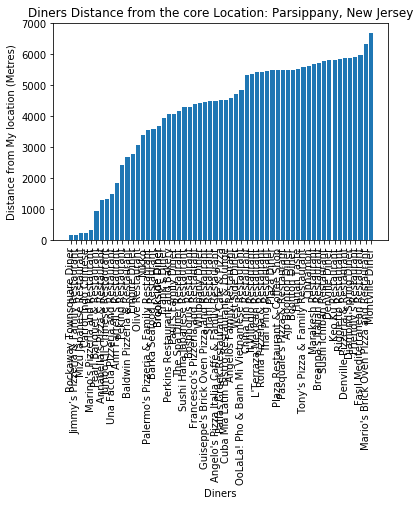

Average distance between Diners and core location is 4157 metres.


In [76]:
distance_diners_df= diners_df[['name','categories','distance','lat','lng']].sort_values('distance')

def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(distance_diners_df.name))
    plt.bar(distance_diners_df.name, distance_diners_df.distance)
    plt.xlabel('Diners')
    plt.ylabel('Distance from My location (Metres)')
    plt.xticks(distance_diners_df.name, rotation = 90)
    plt.title('Diners Distance from the core Location: Parsippany, New Jersey')
    plt.show()
plot_bar_x()

print("Average distance between Diners and core location is {} metres.".format(int(sum(diners_df['distance'])/diners_df.shape[0])))

#### Few points to note:

- Rockaway Townsquare Diner is the closest to the core location.
- Montville Diner is the farthest from the core location
- The average location between Diners and core location is 4157 meters or Approximately 2.5 miles.

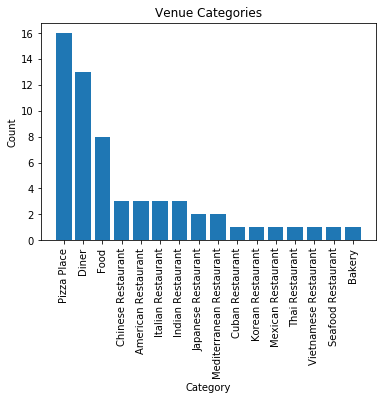

In [77]:
freq_venue=diners_df['categories'].value_counts()
freq_venue=pd.DataFrame(freq_venue).reset_index()
freq_venue.columns=['Category','Count']
freq_venue

def plot_bar_categ():
    # this is for plotting purpose
    index = np.arange(len(freq_venue.Category))
    plt.bar(freq_venue.Category, freq_venue.Count)
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(freq_venue.Category,rotation=90)
    plt.title('Venue Categories')
    plt.show()
plot_bar_categ()

##### Point to Note:

There are 16 pizza places and 13 diners within 4 miles and rest of all are cuisine restaurants and other food places!


## Clustering based on venues

In [94]:
# one hot encoding
neighbor_onehot = pd.get_dummies(diners_df[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
neighbor_onehot['name'] = diners_df['name'] 

# move neighborhood column to the first column
fixed_columns = [neighbor_onehot.columns[-1]] + list(neighbor_onehot.columns[:-1])
neighbor_onehot = neighbor_onehot[fixed_columns]

neighbor_onehot.head()

,name,American Restaurant,Bakery,Chinese Restaurant,Cuban Restaurant,Diner,Food,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Mediterranean Restaurant,Mexican Restaurant,Pizza Place,Seafood Restaurant,Thai Restaurant,Vietnamese Restaurant
0,Rockaway Townsquare Diner,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,Empire Diner,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,Brookside Diner,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,Paul's Family Diner,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,The Spa Diner Resraurant,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [113]:
neighbor_onehot.shape
neighbor_grouped = neighbor_onehot.groupby('name').mean().reset_index()

In [114]:
# Top 10 venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['name'] = neighbor_grouped['name']

In [118]:
# Clustering

# set number of clusters
kclusters = 3

neighbor_grouped_clustering = neighbor_grouped.drop('name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neighbor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Clusters', kmeans.labels_)

neighbor_merged = diners_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
neighbor_merged = neighbor_merged.join(neighborhoods_venues_sorted.set_index('name'), on='name')

kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

## Finding the center of all clusters and midpoint of all venues

In [121]:
fin=neighbor_merged.groupby(['Clusters']).mean()

lati=sum(fin.lat)/len(fin.lat)
longi=sum(fin.lng)/len(fin.lng)

#Taking midpoint of top ten closest hotel
venues_lan=sum(diners_df.lat)/len(diners_df.lat)
venues_lng=sum(diners_df.lng)/len(diners_df.lng)

final_latitude=(lati+venues_lan)/2
final_longitude=(longi+venues_lng)/2

print("Final location (Green Dot in our below given map) of our brand new restaurant:{},{}".format(final_latitude,final_longitude))

Final location (Green Dot in our below given map) of our brand new restaurant:40.861711392145345,-74.42385221102707


## Predicted Location for Opening new restaurant

In [127]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=17)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

folium.CircleMarker(
    [final_latitude, final_longitude],
    radius=10,
    color='green',
    popup='My New Restaurant',
    fill = True,
    fill_color = 'black',
    fill_opacity = 0.6
).add_to(map_clusters)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighbor_merged['lat'], neighbor_merged['lng'], neighbor_merged['name'], neighbor_merged['Clustersss']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

       
map_clusters